In [1]:
! pip install torch_geometric torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=b68928cb5427816e196016d0993ab6ddc3ffa5b6bc32d6b3b8c45db03fe8537b
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=f6c08c048cdbe27a9c3993969f4e83ddbc5b02e7babbc551b5bc5dcf25064b5a
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torch_geometric torchviz


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! if ! [ -d data ]; then cp -r drive/MyDrive/HPCDATA/data .; fi
! if ! [ -d utils ]; then cp -r drive/MyDrive/HPCDATA/utils .; fi

In [4]:
import itertools
import json
import logging
import os
import shutil
from timeit import default_timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
from sklearn.metrics import auc, roc_curve
from torch import nn
from torch_geometric.data import Data, HeteroData
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, HeteroConv
from torchviz import make_dot
from sklearn.metrics import (auc, roc_curve, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report,
                             precision_recall_curve)
from utils.data_processing import *
from utils.training_multigraph import *

from tqdm.notebook import tqdm

In [5]:
AGGREGATED_METRICS_PATH = "data/aggregated/"
JOB_TABLE_PATH = 'data/job_table.parquet'
RACKS_DATA_PATH = 'data/racks_spatial_distribution.json'
DROP_TH = 100
KEEPNODES = np.arange(460,559).astype(str) # set it no None if you don't want to filter nodes

## Read and process metrics table

In [10]:
data = load_metrics(AGGREGATED_METRICS_PATH)
data = process_metrics(data,KEEPNODES,DROP_TH)
data.head()

,timestamp,460,461,463,464,465,467,468,469,470,...,551,552,553,554,555,556,557,558,values,anomalies
0,2022-03-31 02:45:00+00:00,"[0.539976015665201, 0.5405405022263785, 0.5315...","[0.3955845662662844, 0.40540536593020815, 0.37...","[0.4160699413210467, 0.43243241037276337, 0.38...","[0.46081933488446114, 0.47747745580482015, 0.4...","[0.4759347584335139, 0.48648649925787385, 0.45...","[0.5871120678300974, 0.6036036345645427, 0.576...","[0.5280428440482905, 0.5495495456794321, 0.504...","[0.5684167170740713, 0.5945945911114889, 0.540...","[0.612370456611576, 0.6216216355540441, 0.6036...",...,"[0.6630866180691942, 0.6756756385225489, 0.657...","[0.7486076813237196, 0.7477477283971609, 0.747...","[0.7484088436863042, 0.7477477283971609, 0.756...","[0.7758549927365993, 0.7837838162927697, 0.783...","[0.8110581160655834, 0.8108107748187192, 0.819...","[0.7800315542463185, 0.7837838162927697, 0.783...","[0.8337308265224157, 0.8378378192612744, 0.837...","[25.564450412326387, 25.799999237060547, 25.39...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,2022-03-31 03:00:00+00:00,"[0.5129274204992378, 0.5045045002473754, 0.522...","[0.3570007782344892, 0.3513513629617035, 0.360...","[0.3747015766319405, 0.36936936395120507, 0.37...","[0.41865537686469456, 0.4144144093832618, 0.42...","[0.4331741661110016, 0.4234234528363155, 0.432...","[0.5624501919608657, 0.5585585891324859, 0.558...","[0.49602203334669837, 0.4954954567943217, 0.49...","[0.5397770566372865, 0.5495495456794321, 0.531...","[0.590095239343826, 0.5855855476584353, 0.5945...",...,"[0.6591088941968907, 0.6666666809861009, 0.639...","[0.7482098846583893, 0.7477477283971609, 0.738...","[0.749403031873382, 0.7477477283971609, 0.7567...","[0.7750595207964381, 0.7747747728397161, 0.774...","[0.810262401344424, 0.8108107748187192, 0.8108...","[0.7800316756368176, 0.7837838162927697, 0.783...","[0.832338720279509, 0.8378378192612744, 0.8378...","[25.533336046006944, 25.799999237060547, 25.39...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,2022-03-31 03:15:00+00:00,"[0.5151152414633041, 0.5045045002473754, 0.522...","[0.360381867804047, 0.3513513629617035, 0.3603...","[0.37708811384292334, 0.3783784074042587, 0.37...","[0.4196496864422715, 0.4234234528363155, 0.423...","[0.4321796744476762, 0.43243241037276337, 0.43...","[0.5626489689030316, 0.5675675466689337, 0.558...","[0.492442227530224, 0.4954954567943217, 0.4774...","[0.5385837880317951, 0.5495495456794321, 0.522...","[0.5922830603078925, 0.6036036345645427, 0.594...",...,"[0.649562259790963, 0.6576576375330473, 0.6306...","[0.7400557206668658, 0.7387387708607129, 0.738...","[0.7420443398220197, 0.7387387708607129, 0.747...","[0.7690928135974837, 0.7657657293866624, 0.774...","[0.8062846774721205, 0.8018018172822713, 0.810...","[0.7746619669121062, 0.7747747728397161, 0.774...","[0.8287589144630344, 0.8198198182717729, 0.837...","[25.457777235243057, 25.600000381469727, 25.20...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,2022-03-31 03:30:00+00:00,"[0.5079552656588584, 0.5045045002473754, 0.513...","[0.3534208510275159, 0.3513513629617035, 0.360...","[0.3729116130284538, 0.3783784074042587, 0.378...","[0.4188542751973597, 0.4234234528363155, 0.414...","[0.4349641904097378, 0.45045041136226494, 0.43...","[0.5670245501359148, 0.5675675466689337, 0.558...","[0.4996021426394202, 0.5135135437004291, 0.495...","[0.5459426014736564, 0.5585585891324859, 0.540...","[0.5956641498774502, 0.5945945911114889, 0.594...",...,"[0.6549322719919222, 0.6666666809861009, 0.648...","[0.7452264703636629, 0.7477477283971609, 0.747...","[0.7452264703636629, 0.7387387708607129, 0.756...","[0.7716784312268805, 0.7657657293866624, 0.774...","[0.8080744589898586, 0.8018018172822713, 0.810...","[0.777843733282252, 0.7747747728397161, 0.7837...","[0.8311456944550154, 0.8288


## Read Jobs and Racks Tables

In [7]:
node_columns = data.columns[1:-3]
nodes = list(node_columns.astype(int))

racks = pd.read_json(RACKS_DATA_PATH)

jobtable = pd.read_parquet(JOB_TABLE_PATH)[['start_time','end_time','nodes']]
jobtable = jobtable.dropna(subset=['nodes'])
jobtable.nodes = jobtable.nodes.map(lambda x:np.fromstring(x.strip(']['),dtype=int,sep=',')) # map nodelist from str to array
jobtable.nodes = jobtable.nodes.map(lambda a : np.intersect1d(a,nodes)) # Keep only jobs where the selected nodes appear
jobtable = jobtable[jobtable.nodes.map(len)>0] # Drop rows without any node of interest
jobtable = jobtable.reset_index() # Not really necessary, but meh
print("Data covering the period from {} to {}".format(jobtable.start_time.min().date(),jobtable.end_time.max().date()))
jobtable.head()

Data covering the period from 2022-03-31 to 2022-04-30


,index,start_time,end_time,nodes
0,19,2022-04-02 05:36:25+00:00,2022-04-02 13:23:12+00:00,"[529, 530, 531, 532, 533, 534, 535, 536]"
1,237,2022-04-02 13:16:22+00:00,2022-04-02 13:46:35+00:00,[558]
2,780,2022-04-01 23:28:45+00:00,2022-04-01 23:29:22+00:00,"[467, 493, 494, 495, 512, 513, 514]"
3,2096,2022-04-02 16:09:02+00:00,2022-04-02 16:11:31+00:00,"[474, 491, 512, 536, 552]"
4,2953,2022-04-08 22:16:15+00:00,2022-04-09 05:46:26+00:00,"[463, 464, 488, 489, 507, 512, 513, 522, 542]"


In [11]:
data_list = []
job_proximity = ('node', 'same_job', 'node')
node_proximity = ('node', 'same_rack', 'node')

node_columns = data.columns[1:-3]
num_nodes = len(node_columns)
num_node_features = data[node_columns[0]][0].shape[0]

# Build Node proximity graph (global and static)
racks = pd.read_json(RACKS_DATA_PATH)
edgelist_racks = get_edgelist_racks(racks,nodes).apply_(lambda x: nodes.index(x))
eweights_racks = torch.full((edgelist_racks.shape[1],),1.)

# Build Job proximity graphs and create data structures for training
for i,row in tqdm(data.iterrows(), total=len(data)):
  timestamp = row['timestamp']
  jobs = jobtable[(jobtable['start_time']<timestamp) & (jobtable['end_time']>timestamp)]

  edgelist_jobs,eweights_jobs = get_edgelist_jobs(jobs,nodes)

  graph = HeteroData()
  graph[job_proximity] = {
    'edge_index':edgelist_jobs,
    'edge_weight': eweights_jobs,
    }
  graph[node_proximity] = {
    'edge_index':edgelist_racks,
    'edge_weight': eweights_racks}

  graph['node'].num_nodes = num_nodes
  graph['node'].x = torch.tensor(np.stack(row.iloc[1:-2]),dtype = torch.float32)
  graph['node'].id = torch.tensor(nodes)
  data_list.append(graph)

  0%|          | 0/2963 [00:00<?, ?it/s]

## Model Definition

In [12]:
class MLP(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dims = [],
                 activation=F.relu,
                 activate_last=True):
        super().__init__()

        last_hidden_dim = input_dim
        self.hidden_layers = nn.Sequential()
        for dim in hidden_dims:
            self.hidden_layers.append(nn.Linear(last_hidden_dim,dim))
            last_hidden_dim = dim

        self.activation = activation
        self.activate_last = activate_last

        self.output = nn.Linear(last_hidden_dim,output_dim)

    def forward(self,x):
        for layer in self.hidden_layers:
            x = layer(x)
            self.activation(x)

        x = self.output(x)
        if self.activate_last:
            x = self.activation(x)
        return x

class MultiGraphAnomalyPredictor(nn.Module):
    def __init__(self,
                 in_channels,
                 hidden_channels,
                 out_channels,
                 conv_layer=GCNConv,
                 agg = 'sum',
                 **conv_layer_kwargs):
        super().__init__()

        #encoder
        last_hidden_dim = in_channels
        convs = []
        for dim in hidden_channels:
            convs.append((conv_layer(last_hidden_dim, dim, **conv_layer_kwargs),'x,edge_index_jobs,eweight_jobs-> h_j'))
            convs.append((conv_layer(last_hidden_dim, dim, **conv_layer_kwargs),'x,edge_index_racks,eweight_racks-> h_r'))

            if agg == 'mlp':
                convs.append((lambda h_j,h_r:torch.cat((h_j,h_r),dim=1), 'h_j,h_r -> h_s'))
                convs.append((MLP(2*dim,dim),'h_s-> x'))
            elif agg == 'sum':
                convs.append((torch.add, 'h_j,h_r -> x'))
            elif agg == 'mean':
                convs.append((lambda h_j,h_r: (h_j + h_r)/2, 'h_j,h_r -> x'))
            else:
                raise ValueError(f'aggregation type {agg} not supported')
            last_hidden_dim = dim

        self.convs = gnn.Sequential('x,edge_index_jobs, edge_index_racks,eweight_jobs,eweight_racks',convs)
        self.out_layers = MLP(last_hidden_dim,1,out_channels,activate_last=False)


    def forward(self,
                x,
                edge_index_jobs,
                edge_index_racks,
                eweight_jobs=None,
                eweight_racks=None):

        x = self.convs(x,edge_index_jobs,edge_index_racks,eweight_jobs,eweight_racks)
        x = self.out_layers(x)
        return x

convs.module_0.bias torch.Size([300]) 300
convs.module_0.lin.weight torch.Size([300, 416]) 124800
convs.module_1.bias torch.Size([300]) 300
convs.module_1.lin.weight torch.Size([300, 416]) 124800
convs.module_3.output.weight torch.Size([300, 600]) 180000
convs.module_3.output.bias torch.Size([300]) 300
convs.module_4.bias torch.Size([100]) 100
convs.module_4.lin.weight torch.Size([100, 300]) 30000
convs.module_5.bias torch.Size([100]) 100
convs.module_5.lin.weight torch.Size([100, 300]) 30000
convs.module_7.output.weight torch.Size([100, 200]) 20000
convs.module_7.output.bias torch.Size([100]) 100
out_layers.hidden_layers.0.weight torch.Size([16, 100]) 1600
out_layers.hidden_layers.0.bias torch.Size([16]) 16
out_layers.hidden_layers.1.weight torch.Size([1, 16]) 16
out_layers.hidden_layers.1.bias torch.Size([1]) 1
out_layers.output.weight torch.Size([1, 1]) 1
out_layers.output.bias torch.Size([1]) 1
Total trainable Params: 512435


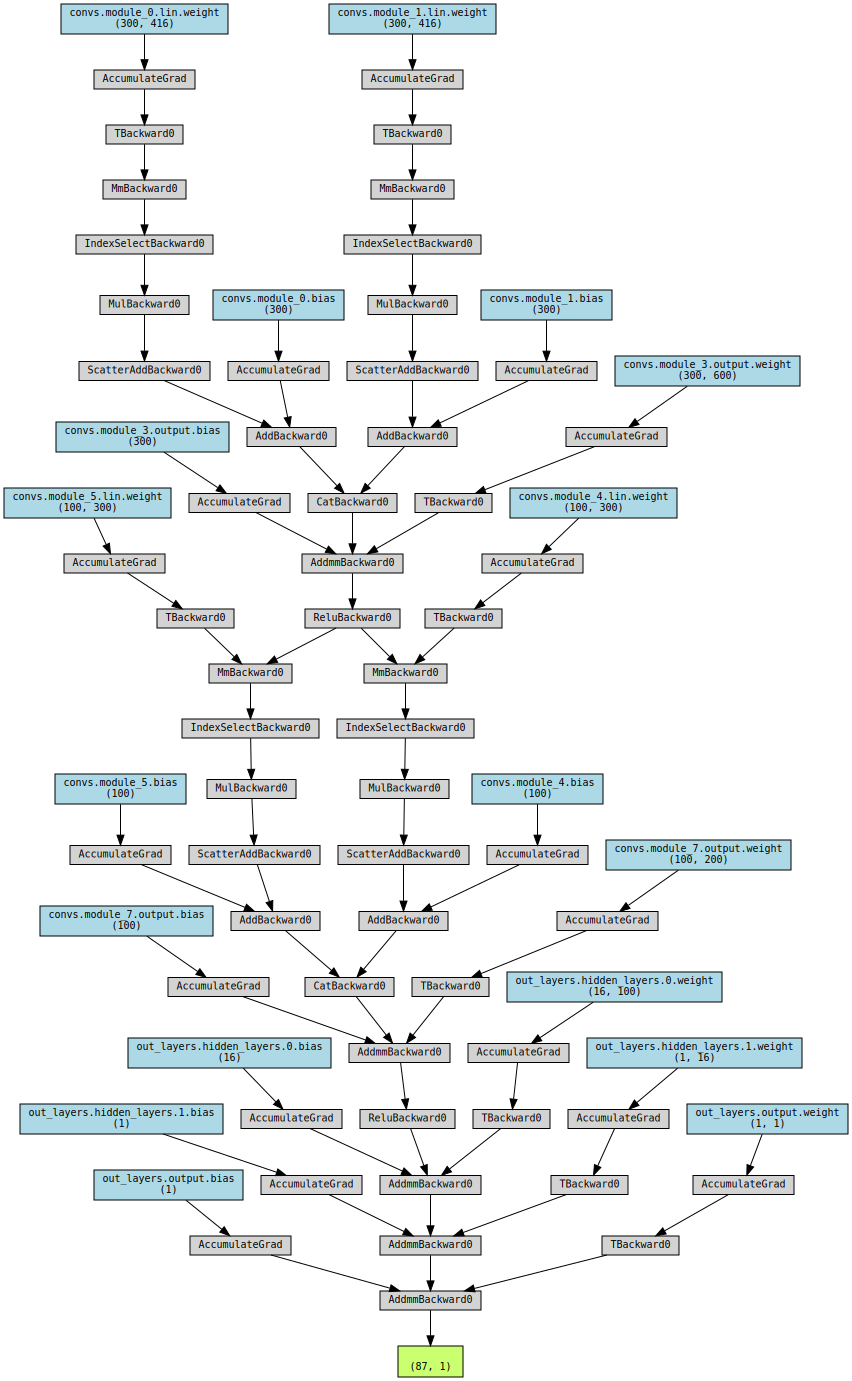

In [13]:
in_channels = num_node_features
HIDDEN_CHANNELS = [300,100]
OUT_CHANNELS = [16,1]
conv_type = GCNConv
agg = 'mlp'
model = MultiGraphAnomalyPredictor(in_channels,HIDDEN_CHANNELS,OUT_CHANNELS,GCNConv,agg)

tot_params = 0
for name,param in model.named_parameters():
    print(name,param.shape,param.numel())
    tot_params += param.numel()
print('Total trainable Params:',tot_params)

g = data_list[0]

x = g['node'].x
edge_list_jobs,eweight_jobs = g[job_proximity].values()
edge_list_racks,eweight_racks = g[node_proximity].values()
out = model (x,edge_list_jobs,edge_list_racks)

make_dot(out, params=dict(list(model.named_parameters())))


In [26]:
def compute_labels(data,window_size):
    labels = []
    for i in tqdm(range(len(data))):
        if i+window_size<len(data):
            anomalies = np.stack(data['anomalies'].iloc[i:i+window_size].values)
            labels.append(anomalies.any(axis=0).astype(int))
        else: # Put them to zero when the number of samples is less than the window size, no relevant data come from here
            labels.append(np.zeros(data['anomalies'][0].shape))
    return torch.tensor(labels)

def train_test_split(data,train_split):
  train_size = int(len(data)*train_split)
  train_data = data[:train_size]
  test_data = data[train_size:]

  return train_data, test_data


def train(train_data, logpath, logger_name, num_epochs, initial_lr, batch_size,es_patience, es_min_delta = 0, apply_weight_balancing = False):

  # Create model
  in_channels, out_channels = num_node_features, 16
  model = MultiGraphAnomalyPredictor(in_channels,HIDDEN_CHANNELS,OUT_CHANNELS,GCNConv,agg)

  # Prepare dataloader
  train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = False)

  # Compute weight balancing
  pos_weight = None
  if APPLY_WEIGHT_BALANCING:
    train_labels = torch.cat([g['node'].y for g in train_data])
    train_ones = len(train_labels.nonzero())
    train_zeros = len(train_labels)-train_ones
    pos_weight = torch.tensor(train_zeros/train_ones)

  # Set up training
  criterion = torch.nn.BCEWithLogitsLoss(weight = pos_weight)
  optimizer = torch.optim.Adam([p for p in model.parameters()],lr = initial_lr)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epochs,eta_min=initial_lr * 1e-1)
  trainer =  MyTrainer(model,
                       optimizer,
                       scheduler,
                       es_patience,
                       es_min_delta)

  trainer.train(num_epochs,criterion,train_loader,logger_name,device,logpath)
  model.load_state_dict(torch.load(os.path.join(logpath,'BestModel/best-model.pt'))['model'])
  return model

def get_predictions(model,dataloader,device):
    model.eval()
    preds = []
    y_true = []
    with torch.no_grad():
        for g in tqdm(dataloader):
          g = g.to(device)
          x = g['node'].x
          y = g['node'].y
          edge_list_jobs,eweight_jobs = g[('node','same_job','node')].values()
          edge_list_racks,eweight_racks = g[('node','same_rack','node')].values()

          # Forward pass
          logits = model (x,edge_list_jobs,edge_list_racks,eweight_jobs,eweight_racks).squeeze()

          pred = torch.sigmoid(logits)
          preds.append(pred.detach().cpu().numpy())
          y_true.append(y.detach().cpu().numpy())

    preds = np.concatenate(preds).astype(float)
    y_true = np.concatenate(y_true).astype(int)

    return pd.DataFrame({'prob': preds,'true_class': y_true})

In [15]:
def plot_roc_curve(predictions,save_as=None):
    plt.figure(figsize=(10,9))
    plt.rcParams['font.size'] = 15
    fpr,tpr,thr = roc_curve(predictions['true_class'], predictions['prob'], pos_label=None, sample_weight=None, drop_intermediate=True)

    plt.grid()
    plt.plot(fpr,tpr,color='darkorange')
    plt.plot((0,1),(0,1),linestyle='--',color='grey',alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend([f'Anomaly Detection (AUC={auc(fpr,tpr):.2f})'])

    plt.title("ROC curve")

    if save_as is not None:
      plt.savefig(save_as)
    plt.show()
    return fpr,tpr,thr

def plot_pr_curve(predictions,save_as=None):
    plt.figure(figsize=(10,9))
    plt.rcParams['font.size'] = 15
    prec,rec,thr = precision_recall_curve(predictions['true_class'], predictions['prob'])

    plt.grid()
    plt.plot(prec,rec,color='darkorange')
    plt.plot((0,1),(0,1),linestyle='--',color='grey',alpha=0.5)
    plt.xlabel("Precision")
    plt.ylabel("Recall")

    plt.title("Precision/Recall curve")
    if save_as is not None:
      plt.savefig(save_as)
    plt.show()

def plot_classification_report(predictions, th, save_fig_as=None):
    y_pred = predictions['prob']>th
    y_true = predictions['true_class']

    cm = confusion_matrix(y_true,y_pred)
    disp  = ConfusionMatrixDisplay(cm)
    disp.plot()
    if save_fig_as is not None:
      plt.savefig(save_fig_as)
    plt.show()

    print("\nClassification Report")
    print(classification_report(y_true,y_pred))

def plot_distributions(predictions, th,save_as = None):
    plt.figure(figsize=(10,10))
    plt.yscale('log')
    predictions['prob'].hist(bins = 200,color='black')
    predictions[predictions['true_class']==0]['prob'].hist(bins = 200,color='lime',alpha=0.7,)
    predictions[predictions['true_class']==1]['prob'].hist(bins = 200,color='red',alpha=0.7)
    ylim = plt.gca().get_ylim()

    plt.vlines(th, *ylim,color='blue')
    plt.gca().set_ylim(ylim)
    plt.legend(['Threshold','Global Distrib.','Negative Distrib.','Positive Distrib.'])
    if save_as is not None:
      plt.savefig(save_as)
    plt.show()

## Training Setup

In [30]:
TRAIN_SPLIT = 0.7
NUM_EPOCHS = 1
INITIAL_LR = 1e-3

TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

ES_PATIENCE = 50
ES_MIN_DELTA = 0

APPLY_WEIGHT_BALANCING = False # whether to use weight balancing inside the loss

LOGGER_NAME = f'train.output'
BASE_LOGPATH = f'out'
# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Available device:',device)

if not os.path.exists(BASE_LOGPATH):
  os.makedirs(BASE_LOGPATH)

Available device: cpu


## Window size 4

In [31]:
window_size = 4
labels = compute_labels(data,window_size)
for i,g in enumerate(data_list):
  g['node'].y = labels[i]

  0%|          | 0/2963 [00:00<?, ?it/s]

In [32]:
train_data, test_data = train_test_split(data_list,TRAIN_SPLIT)
logpath = f'{BASE_LOGPATH}/{window_size:02d}'
logger_name = f'{logpath}/{LOGGER_NAME}'
model = train(train_data, logpath, logger_name, NUM_EPOCHS, INITIAL_LR, TRAIN_BATCH_SIZE,ES_PATIENCE, ES_MIN_DELTA,APPLY_WEIGHT_BALANCING)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/1	 Train Loss: 0.14307134756813975, Train Acc at 50%: 0.9907170329974839


In [33]:
test_loader = DataLoader(test_data, batch_size = TEST_BATCH_SIZE, shuffle = False)
predictions = get_predictions(model,test_loader,device)
predictions.to_csv(os.path.join(logpath,'predictions.csv'))

  0%|          | 0/14 [00:00<?, ?it/s]

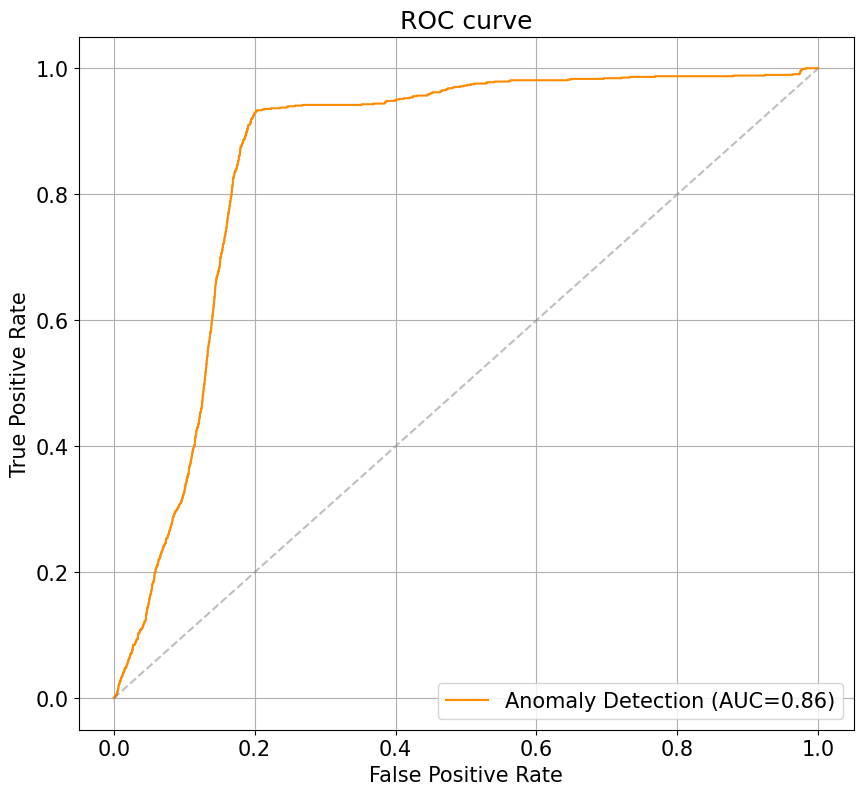

In [34]:
fpr,tpr,thr = plot_roc_curve(predictions,save_as=os.path.join(logpath,'ROC_curve.png'))
th = thr[np.argmax(tpr-fpr)]
print(f"\nBest probability threshold: p={th*100:.2f}%")


Best probability threshold: p=1.35%


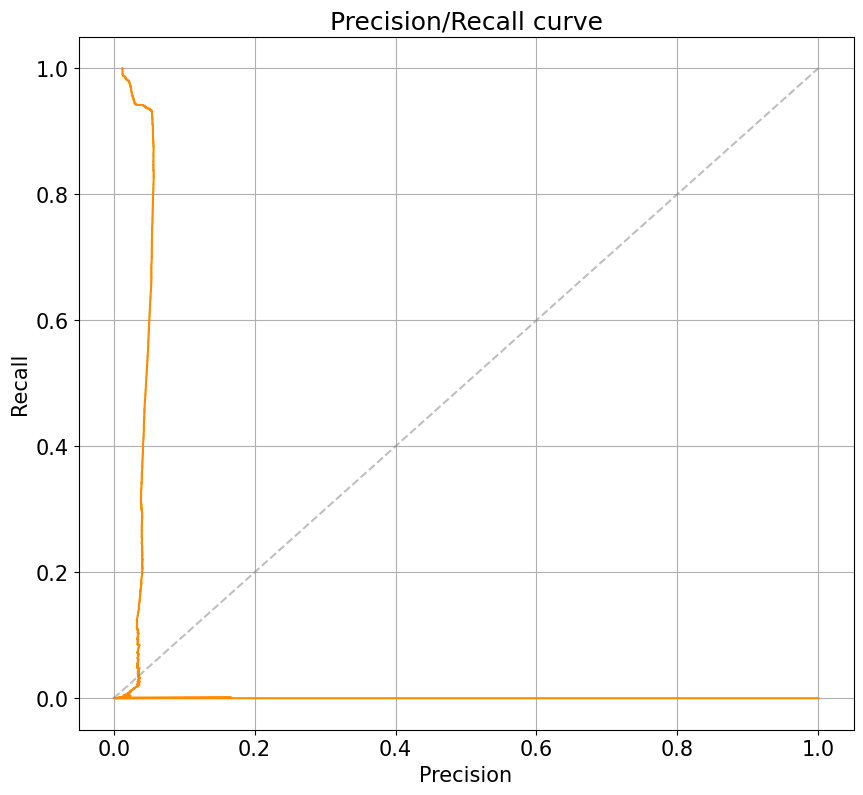

In [35]:
plot_pr_curve(predictions,save_as=os.path.join(logpath,'PR_curve.png'))

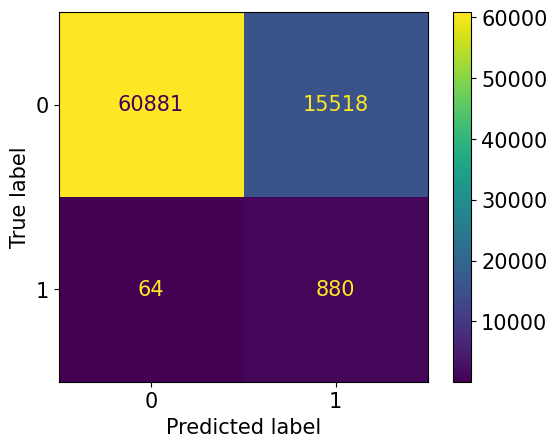


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     76399
           1       0.05      0.93      0.10       944

    accuracy                           0.80     77343
   macro avg       0.53      0.86      0.49     77343
weighted avg       0.99      0.80      0.88     77343



In [36]:
plot_classification_report(predictions,th,save_fig_as=os.path.join(logpath,'CM.png'))

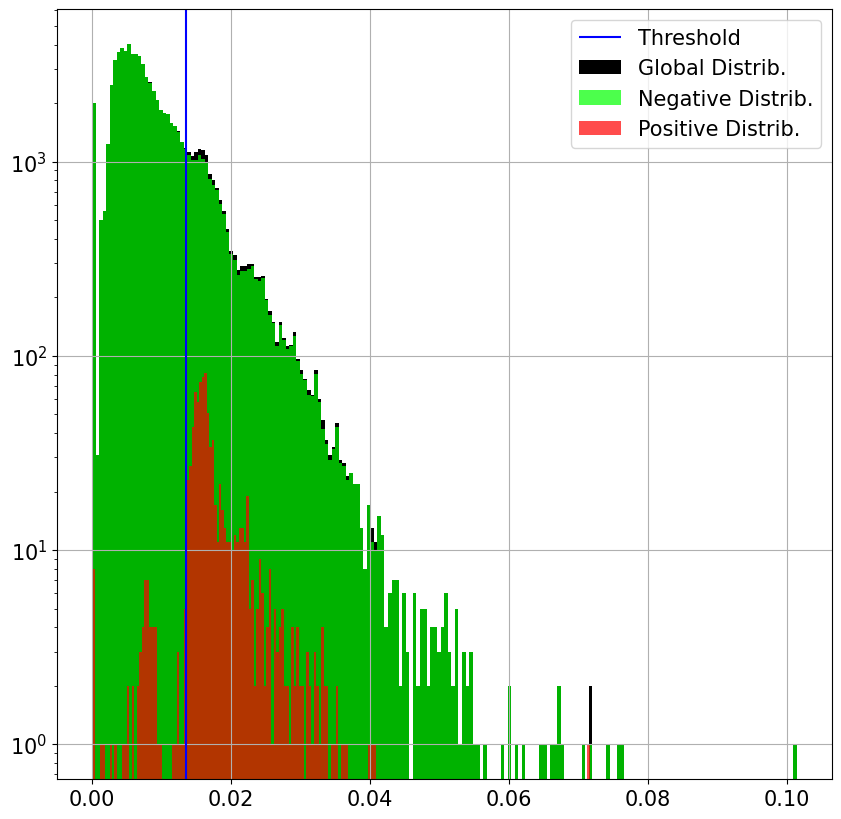

In [37]:
plot_distributions(predictions, th,save_as=os.path.join(logpath,'Prob_distr.png'))

## Window size 24

In [38]:
window_size = 24
labels = compute_labels(data,window_size)
for i,g in enumerate(data_list):
  g['node'].y = labels[i]

  0%|          | 0/2963 [00:00<?, ?it/s]

In [39]:
train_data, test_data = train_test_split(data_list,TRAIN_SPLIT)
logpath = f'{BASE_LOGPATH}/{window_size:02d}'
logger_name = f'{logpath}/{LOGGER_NAME}'
model = train(train_data, logpath, logger_name, NUM_EPOCHS, INITIAL_LR, TRAIN_BATCH_SIZE,ES_PATIENCE, ES_MIN_DELTA,APPLY_WEIGHT_BALANCING)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/1	 Train Loss: 0.10653041358042652, Train Acc at 50%: 0.9896141610968865


In [40]:
test_loader = DataLoader(test_data, batch_size = TEST_BATCH_SIZE, shuffle = False)
predictions = get_predictions(model,test_loader,device)
predictions.to_csv(os.path.join(logpath,'predictions.csv'))

  0%|          | 0/14 [00:00<?, ?it/s]

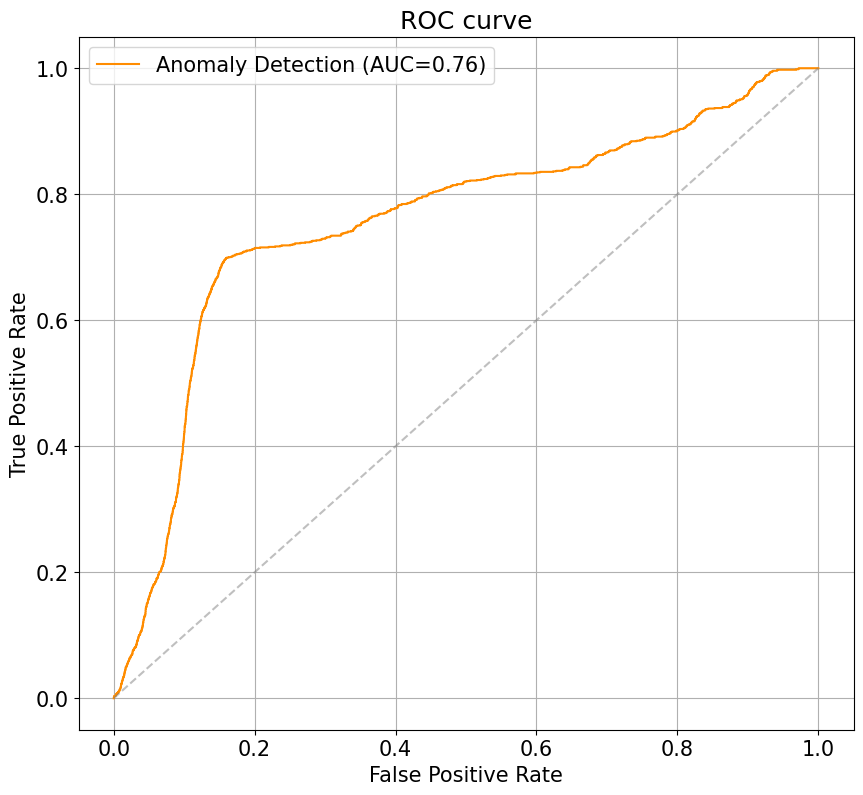


Best probability threshold: p=0.15%


In [41]:
fpr,tpr,thr = plot_roc_curve(predictions,save_as=os.path.join(logpath,'ROC_curve.png'))
th = thr[np.argmax(tpr-fpr)]
print(f"\nBest probability threshold: p={th*100:.2f}%")

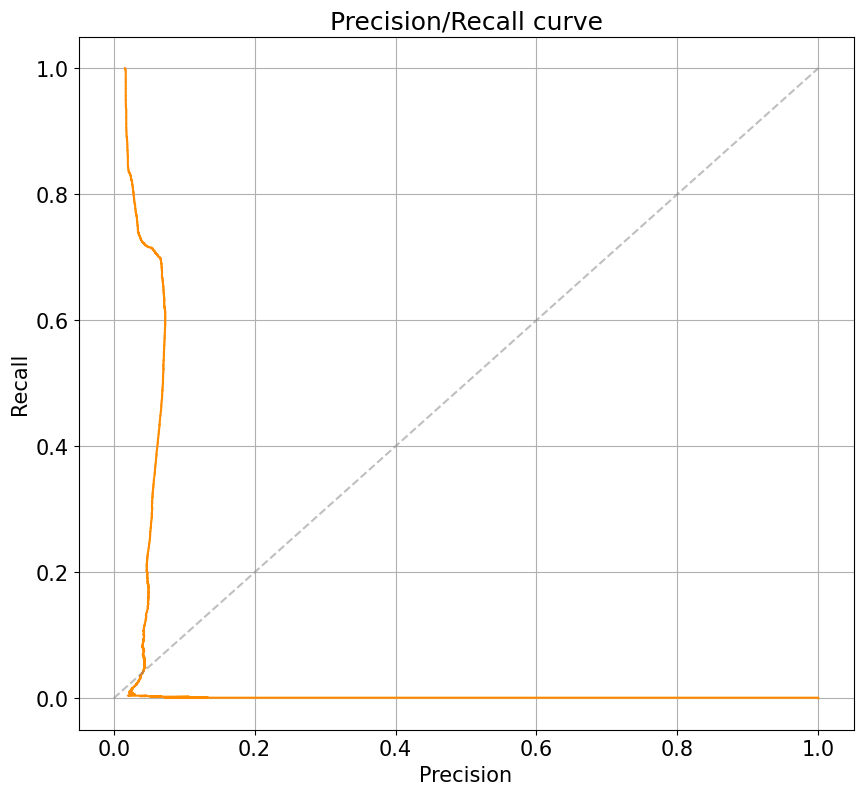

In [42]:
plot_pr_curve(predictions,save_as=os.path.join(logpath,'PR_curve.png'))

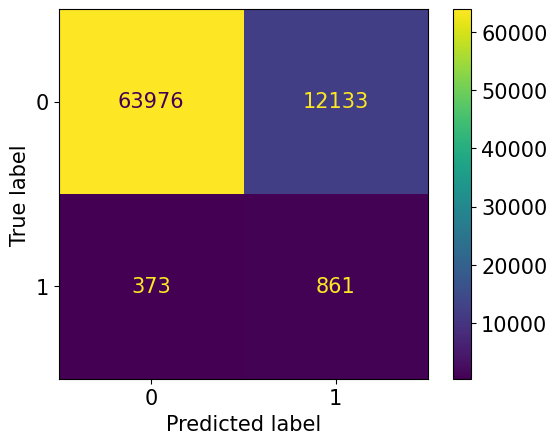


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     76109
           1       0.07      0.70      0.12      1234

    accuracy                           0.84     77343
   macro avg       0.53      0.77      0.52     77343
weighted avg       0.98      0.84      0.90     77343



In [43]:
plot_classification_report(predictions,th,save_fig_as=os.path.join(logpath,'CM.png'))

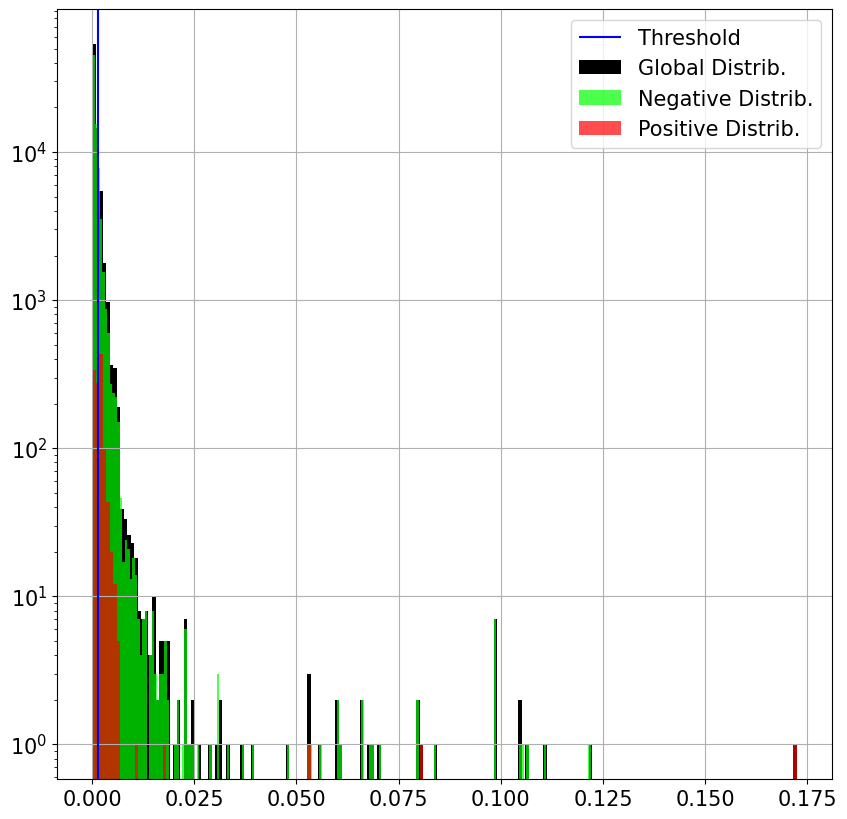

In [44]:
plot_distributions(predictions, th,save_as=os.path.join(logpath,'Prob_distr.png'))

## Window size 64

In [45]:
window_size = 64
labels = compute_labels(data,window_size)
for i,g in enumerate(data_list):
  g['node'].y = labels[i]

  0%|          | 0/2963 [00:00<?, ?it/s]

In [46]:
train_data, test_data = train_test_split(data_list,TRAIN_SPLIT)
logpath = f'{BASE_LOGPATH}/{window_size:02d}'
logger_name = f'{logpath}/{LOGGER_NAME}'
model = train(train_data, logpath, logger_name, NUM_EPOCHS, INITIAL_LR, TRAIN_BATCH_SIZE,ES_PATIENCE, ES_MIN_DELTA,APPLY_WEIGHT_BALANCING)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/1	 Train Loss: 0.2051474008731531, Train Acc at 50%: 0.963145235482548


In [47]:
test_loader = DataLoader(test_data, batch_size = TEST_BATCH_SIZE, shuffle = False)
predictions = get_predictions(model,test_loader,device)
predictions.to_csv(os.path.join(logpath,'predictions.csv'))

  0%|          | 0/14 [00:00<?, ?it/s]

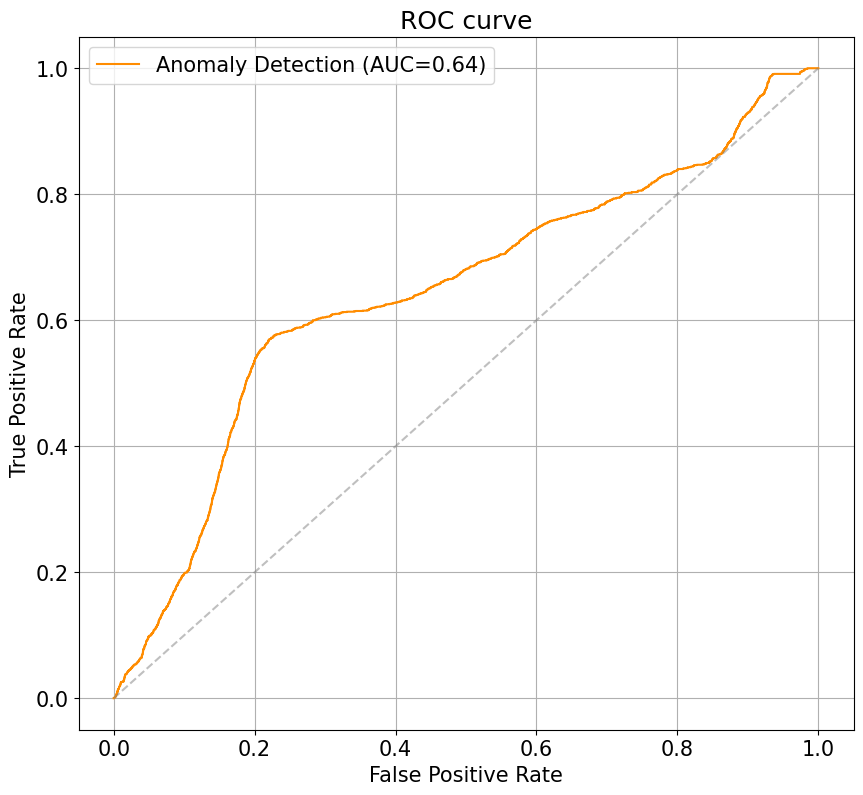


Best probability threshold: p=1.44%


In [48]:
fpr,tpr,thr = plot_roc_curve(predictions,save_as=os.path.join(logpath,'ROC_curve.png'))
th = thr[np.argmax(tpr-fpr)]
print(f"\nBest probability threshold: p={th*100:.2f}%")

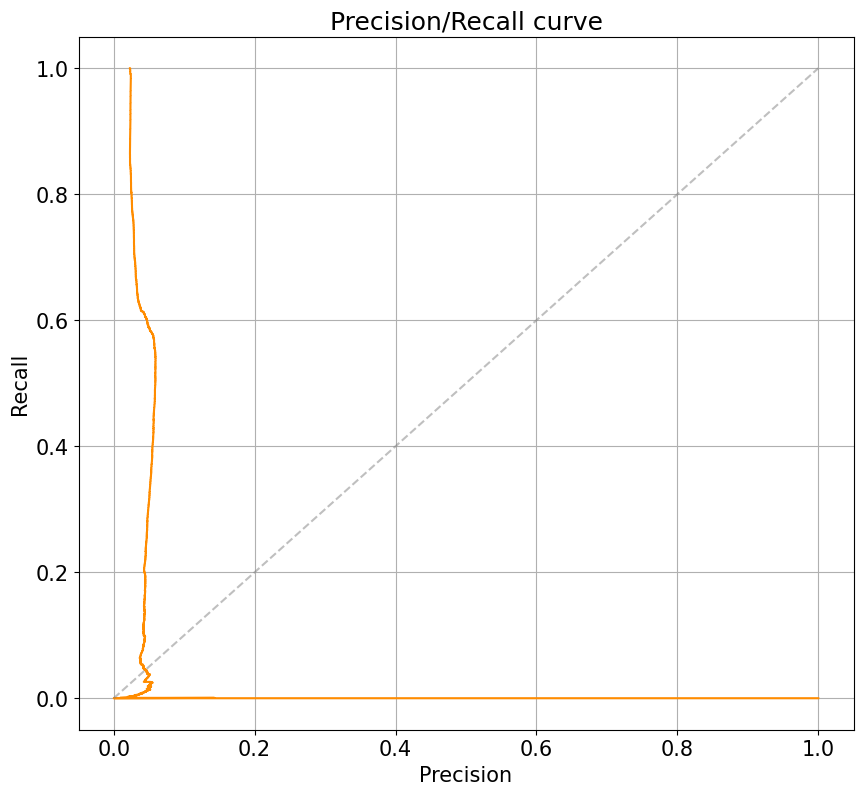

In [49]:
plot_pr_curve(predictions,save_as=os.path.join(logpath,'PR_curve.png'))

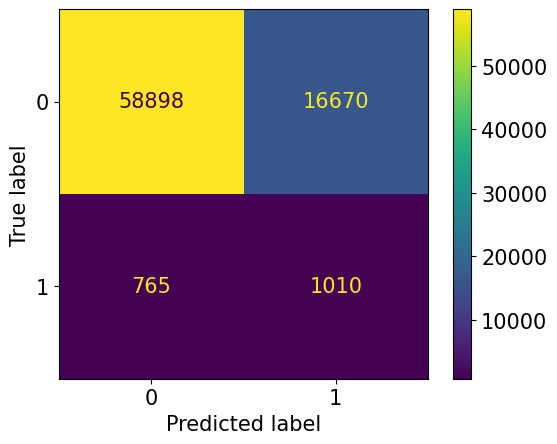


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.78      0.87     75568
           1       0.06      0.57      0.10      1775

    accuracy                           0.77     77343
   macro avg       0.52      0.67      0.49     77343
weighted avg       0.97      0.77      0.85     77343



In [50]:
plot_classification_report(predictions,th,save_fig_as=os.path.join(logpath,'CM.png'))

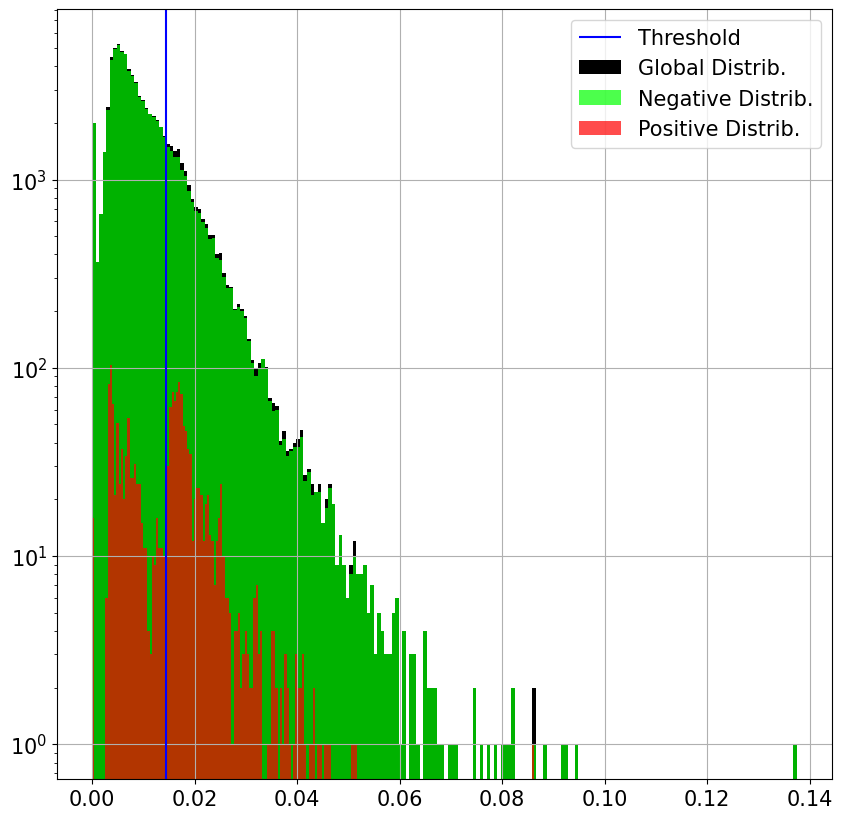

In [51]:
plot_distributions(predictions, th,save_as=os.path.join(logpath,'Prob_distr.png'))

## Window size 192

In [52]:
window_size = 192
labels = compute_labels(data,window_size)
for i,g in enumerate(data_list):
  g['node'].y = labels[i]

  0%|          | 0/2963 [00:00<?, ?it/s]

In [53]:
train_data, test_data = train_test_split(data_list,TRAIN_SPLIT)
logpath = f'{BASE_LOGPATH}/{window_size:02d}'
logger_name = f'{logpath}/{LOGGER_NAME}'
model = train(train_data, logpath, logger_name, NUM_EPOCHS, INITIAL_LR, TRAIN_BATCH_SIZE,ES_PATIENCE, ES_MIN_DELTA,APPLY_WEIGHT_BALANCING)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/1	 Train Loss: 0.25919219395997517, Train Acc at 50%: 0.9424068100954345


In [54]:
test_loader = DataLoader(test_data, batch_size = TEST_BATCH_SIZE, shuffle = False)
predictions = get_predictions(model,test_loader,device)
predictions.to_csv(os.path.join(logpath,'predictions.csv'))

  0%|          | 0/14 [00:00<?, ?it/s]

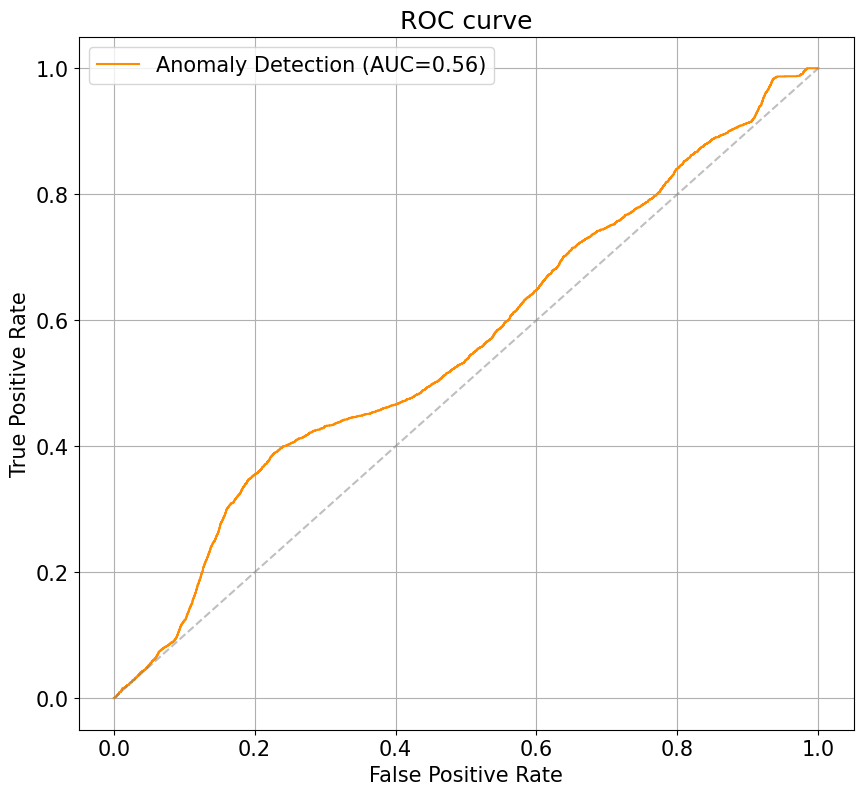


Best probability threshold: p=1.14%


In [55]:
fpr,tpr,thr = plot_roc_curve(predictions,save_as=os.path.join(logpath,'ROC_curve.png'))
th = thr[np.argmax(tpr-fpr)]
print(f"\nBest probability threshold: p={th*100:.2f}%")

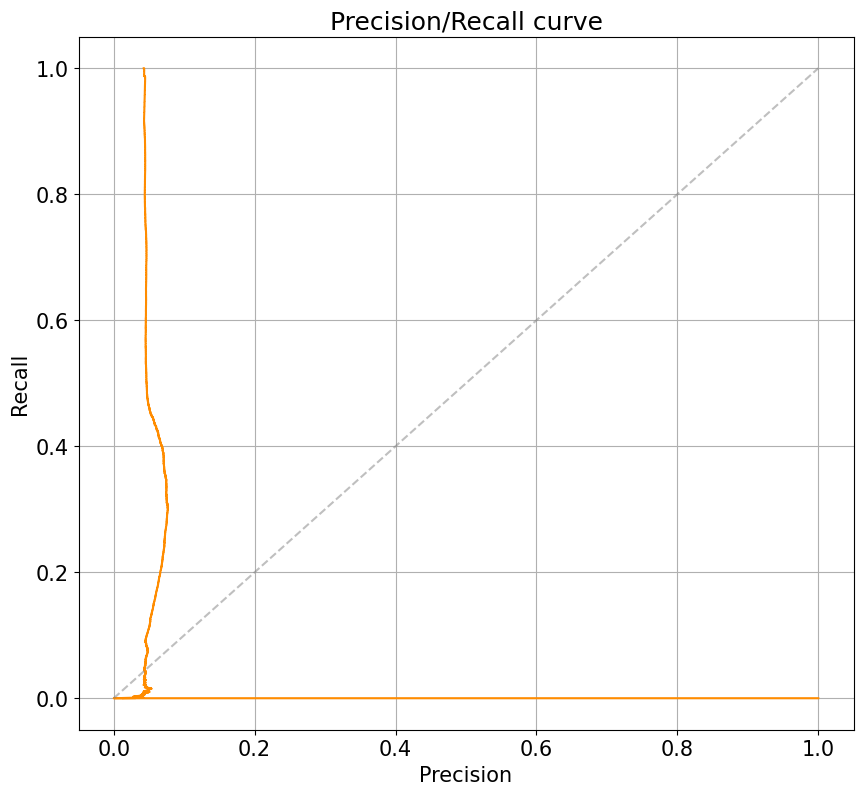

In [56]:
plot_pr_curve(predictions,save_as=os.path.join(logpath,'PR_curve.png'))

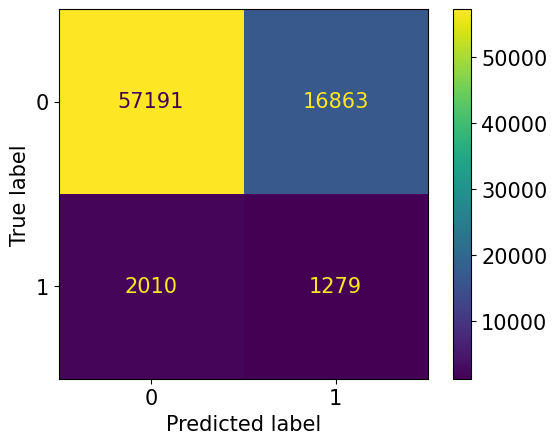


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     74054
           1       0.07      0.39      0.12      3289

    accuracy                           0.76     77343
   macro avg       0.52      0.58      0.49     77343
weighted avg       0.93      0.76      0.83     77343



In [57]:
plot_classification_report(predictions,th,save_fig_as=os.path.join(logpath,'CM.png'))

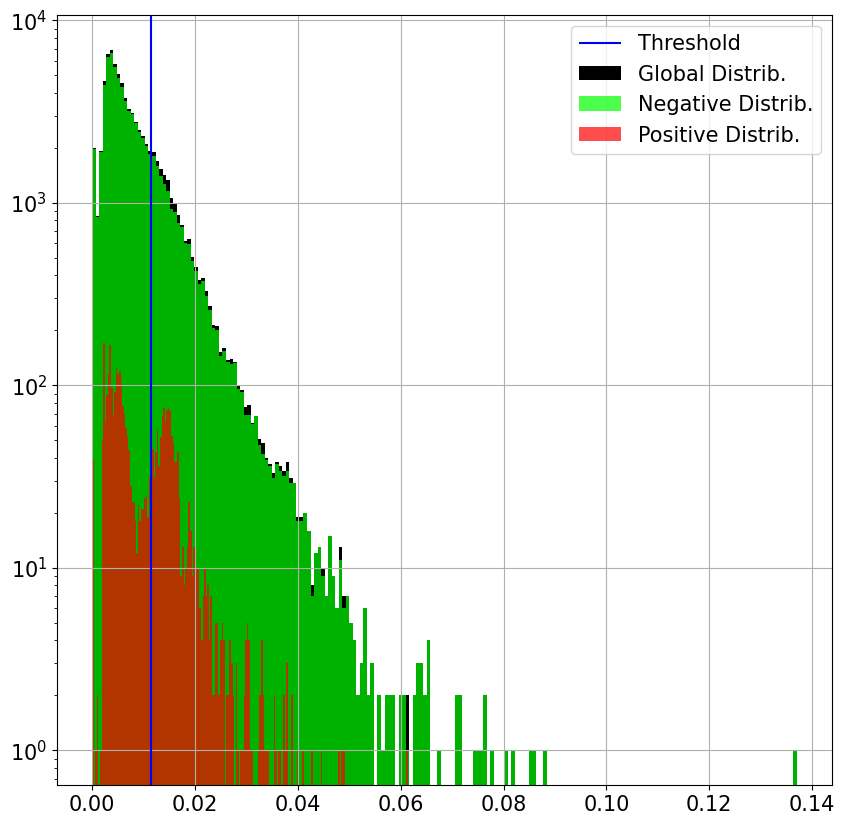

In [58]:
plot_distributions(predictions, th,save_as=os.path.join(logpath,'Prob_distr.png'))